In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import os
import json
from PIL import Image
import numpy as np
#import gdown
from tqdm import tqdm
import matplotlib.pyplot as plt

如何理解 CNN on Deepseek https://chat.deepseek.com/share/hr7spr0zmlvv91z2od

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
!nvidia-smi

Thu Nov  6 10:41:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.57                 Driver Version: 581.57         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   60C    P0             16W /   50W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
!git clone https://github.com/steven-lunar/GenAI-ML-HW6.git
%cd ./GenAI-ML-HW6/

c:\enlist\LLMLearning\GenAICourse\GenAI-ML-HW6


Cloning into 'GenAI-ML-HW6'...


In [13]:
train_transform = transforms.Compose([
    ## We resize all images to a specific size, 128 * 128 here
    ## You can resize them into other size, yet you may need to modify the architecture of model to fit the input shape
    transforms.Resize((128, 128)),

    ## TODO: Add your personalized transformation here##
    ## You may reference https://docs.pytorch.org/vision/0.11/transforms.html#automatic-augmentation-transforms

    ## Examples:
    ## transforms.RandomVerticalFlip(p=0.5)   # Filp the image vertically
    ## transforms.RandomHorizontalFlip(p=0.5)  # Filp the image horizontally

    ## Transform the numpy array to the torch tensor
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),

    ## TODO: You may using test-time augmentation here (not necessary if you only want to pass all baselines)
    ## You can implement it if you want.
    transforms.ToTensor(),
])

RuntimeError: Numpy is not available

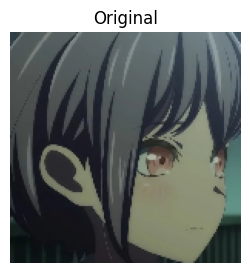

In [16]:
img_path = "./train/0.png"
img = Image.open(img_path).convert("RGB")

transform_list = {
    "Original": transforms.Compose([]),

    "GaussianBlur": transforms.GaussianBlur(kernel_size=9)
}

n = len(transform_list)
plt.figure(figsize=(12, 3))
for i, (name, t) in enumerate(transform_list.items()):
    transformed_img = t(img)
    plt.subplot(1, n, i + 1)
    plt.imshow(transformed_img)
    plt.title(name)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [18]:
label2class = {
    "anon": 0,
    "mutsumi": 1,
    "nyamuchi": 2,
    "rana": 3,
    "sakiko": 4,
    "soyo": 5,
    "taki": 6,
    "tomori": 7,
    "uika": 8,
    "umiri": 9
    ## "mana": 10   ...only appears in few sences...
}

In [19]:
class MyGOCharacterDataset(Dataset):
    def __init__(self, json_path, images_dir, transform=None):
        """
        Args:
            json_path (str): Path to the json file with the metadata for this dataset (eg. train.json, valid.json, test.json)
            images_dir (str): Path to the images directory (eg. ./train/)
            transform (callable, optional): The transformation set you create (train_transform)
        """
        self.images_dir = images_dir
        self.transform = transform

        ## load metadata
        with open(json_path, 'r', encoding='utf-8') as f:
            self.metadata = json.load(f)

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        attr = self.metadata[idx]
        img_path = os.path.join(self.images_dir, attr['filename'])
        idx = attr["id"]
        ## Images are opened with RGB channels, 3 channels
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            ## If there is transformations defined, we implement these transformations on our images
            image = self.transform(image)

        if "test" in self.images_dir:
            ## No label for the testing set, so we don't return labels
            return image, idx
        else:
            label = attr['label']
            label = label2class[label]
            return image, label, idx

In [21]:
train_set = MyGOCharacterDataset(
    json_path='./train/train.json',
    images_dir='./train',
    transform=train_transform
)

val_set = MyGOCharacterDataset(
    json_path='./valid/valid.json',
    images_dir='./valid',
    transform=train_transform
)

test_set = MyGOCharacterDataset(
    json_path='./test/test.json',
    images_dir='./test',
    transform=test_transform
)

In [22]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [24]:
class MyLinearModel(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        ## TODO: You may modify the linear model here to archieve better performance
        self.simple_linear = nn.Sequential(
            nn.Flatten(),                  # Flatten the image data into a 1D-vector
            nn.Linear(128 * 128 * 3, 4096),       # Fully-connected layer
            nn.ReLU(),                    # Activation function, ReLU here, can change it with other functions
            nn.Linear(4096, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)          # Using linear layer to map output with number of classes, 10
        )

    def forward(self, x):
        return self.simple_linear(x)

In [25]:
class MyCNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        ## TODO: Modify the CNN architecture here to get better performance
        ## - Wider
        ## - Deeper
        ## - Not so much downsample to preserve more information in the images (i.e. adjust the kernal size)
        ## - Dropout (nn.Dropout(p), reference: https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html)


        ## Pay attention to the input shape, it may not suit your modified model!!
        ## The default input shape here is [batch_size, 128, 128, 3]
        self.simple_CNN = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),      # Convolution layer to capture the features in the image
            nn.BatchNorm2d(32),             # Batch normalization
            nn.ReLU(),                      # Activation function
            nn.MaxPool2d(8, 8, 0),          # Maxpooling to downsample the image and only preserve important information

            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(8, 8, 0),

            nn.Flatten(),                   # Flatten the image data into a 1D-vector

            nn.Linear(64 * 2 * 2, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )


        ## TODO: You may use the pre-defined model in this task
        ## You may choose the pre-defined model for yourself
        ## Useful pre-defined model list: https://docs.pytorch.org/vision/main/models.html
        ## Maybe pre-trained weight?

        ## Example:
        ## self.resnet18 = torchvision.models.resnet18(pretrained=False)

        ## You still need to modify the forward() function below to use these pre-defined models on the image
        ## Remember to check the input and output shape of these pre-defined models!

    def forward(self, x):
        return self.simple_CNN(x)

In [26]:
## You can change the directory for saving the model weight
save_dir = "./linear/"
os.makedirs(save_dir, exist_ok=True)  # To create the saving directory

In [27]:
seed = 42   # You may change random seed here
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)